## Rennes Data Challenge 2023 

Mathis Derenne

---

### Prophet model

Prophet model provide a simple forecasting method. It doesn't take into account exogenous variables and is based on a time series decomposition.

In [46]:
import pandas as pd
from matplotlib import pyplot as plt
from utils import load_data, validation_split

In [47]:
_, y = load_data()
y = pd.DataFrame(y)
y = y.reset_index()
y = y.rename(columns={'date': 'ds', 'Close_BTC': 'y'})

In [48]:
from sklearn.model_selection import ParameterGrid

grid = {
    'changepoint_prior_scale': [0.05, 0.2, 1.0, 3.0],
    'seasonality_prior_scale': [0.1, 10.0],
    'seasonality_mode': ['multiplicative']
}

params_grid = ParameterGrid(grid)
len(params_grid)

8

In [53]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, r2_score

cutoffs = pd.date_range(start = validation_split, end = y.ds.max(), freq='B') - pd.Timedelta('1 day')
# -1 day is required here because prophet uses cutoffs + horizon (here 1 day) to create prediction intervals 

results = pd.DataFrame(columns=['params', 'r2_score', 'mse_score', 'pred'])

for p in params_grid:            
    model = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
    )

    model.fit(y)
    df_cv = cross_validation(model, horizon = '1 day', cutoffs=cutoffs, parallel="processes")
    
    # Save result
    new_row = pd.DataFrame(
        {   'params': [p],
            'r2_score' : [r2_score(df_cv.y, df_cv.yhat)],
            'mse_score' : [mean_squared_error(df_cv.y, df_cv.yhat)],
            'pred' : [df_cv]
        })
    results = pd.concat([results, new_row], ignore_index=True)

14:07:11 - cmdstanpy - INFO - Chain [1] start processing
14:07:11 - cmdstanpy - INFO - Chain [1] done processing
14:07:12 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [

In [54]:
results = results.sort_values('r2_score', ascending=False)
display(results.head(3))

,params,r2_score,mse_score,pred
5,"{'changepoint_prior_scale': 1.0, 'seasonality_...",-0.679334,1.460313e+07,ds yhat yhat_lower ...
7,"{'changepoint_prior_scale': 3.0, 'seasonality_...",-0.691279,1.470700e+07,ds yhat yhat_lower ...
3,"{'changepoint_prior_scale': 0.2, 'seasonality_...",-0.714413,1.490817e+07,ds yhat yhat_lower ...


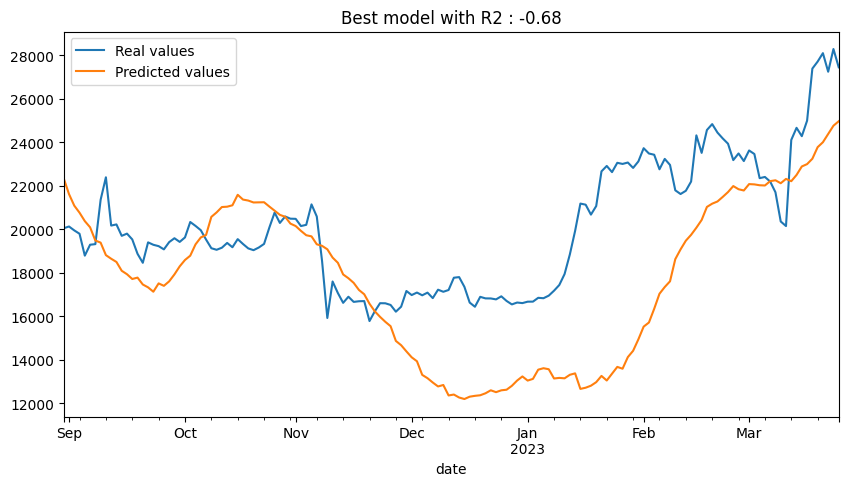

In [57]:
best_pred = results.iloc[0]['pred']
best_pred = best_pred.rename(columns={'ds' : 'date'})
best_pred = best_pred.set_index('date')

# Plot the best prediction
plt.figure(figsize=(10, 5))
best_pred['y'].plot(label='Real values')
best_pred['yhat'].plot(label='Predicted values')

plt.legend()
plt.title(f"Best model with R2 : {results.iloc[0]['r2_score']:0.2f}");

In [59]:
# Save prediction of the model
best_pred = best_pred[['yhat']]
best_pred = best_pred.rename(columns={'yhat': 'Close_BTC'})
best_pred.to_csv('prediction/prophet_pred.csv')